## Using GPU

Go to `Runtime > Change runtime type` and set `Hardware accelerator` to `GPU`. This will reset Colab. **Rerun the top cell to mount your Drive again.**

# 生成对抗网络（GANs）

在CS 231N课程中，我们迄今为止探索的所有神经网络应用都是**判别模型**，即接受输入并经过训练以产生标注输出。这些应用涵盖了从简单的图像类别分类到句子生成（尽管后者仍被表述为分类问题，我们的标签位于词汇空间，且我们通过学习递归模型来捕捉多词标签）。在本笔记本中，我们将拓展我们的技能，利用神经网络构建**生成模型**。具体而言，我们将学习如何构建能够生成与训练图像集相似的全新图像的模型。

### 什么是 GAN？

2014 年，[Goodfellow 等](https://arxiv.org/abs/1406.2661) 提出了一种训练生成模型的方法，称为生成对抗网络（GAN）。在 GAN 中，我们构建两个不同的神经网络。我们的第一个网络是一个传统的分类网络，称为**判别器**。我们将训练判别器来接收图像并将其分类为真实（属于训练集）或虚假（不在训练集中）。另一个网络称为**生成器**，它将随机噪声作为输入，并通过神经网络进行转换以生成图像。生成器的目标是欺骗判别器，使其认为生成的图像为真实图像。

我们可以将生成器（$G$）试图欺骗判别器（$D$）以及判别器试图正确分类真实与伪造图像的过程视为一个最小最大游戏：
$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
其中 $z \sim p(z)$ 是随机噪声样本，$G(z)$ 是使用神经网络生成器 $G$ 生成的图像，而 $D$ 是判别器的输出，指定输入为真实图像的概率。在[Goodfellow et al.](https://arxiv.org/abs/1406.2661)中，他们分析了这个最小最大游戏，并展示了它如何与训练数据分布与$G$生成的样本之间的Jensen-Shannon散度最小化相关。

为了优化这个最小最大游戏，我们将交替进行以下操作：对 $G$ 的目标函数进行梯度下降更新，对 $D$ 的目标函数进行梯度上升更新：
1. 更新 **生成器** ($G$) 以最小化鉴别器做出正确选择的概率。
2. 更新**判别器**（$D$）以最大化判别器做出正确选择的概率。

尽管这些更新对分析有用，但在实际应用中表现不佳。因此，我们在更新生成器时将采用不同的目标函数：最大化判别器做出错误选择的概率。这一微小改动有助于缓解生成器梯度消失的问题，尤其当鉴别器自信时。这是大多数GAN论文中采用的标准更新方式，并在[Goodfellow等](https://arxiv.org/abs/1406.2661)的原始论文中被使用。

在本作业中，我们将交替进行以下更新：
1. 更新生成器($G$)以最大化判别器在生成数据上做出错误选择的概率：
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. 更新判别器（$D$），以最大化判别器在真实数据和生成数据上做出正确选择的概率：
$$\underset{D}{\text{最大化}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

以下是您将要训练的3个不同模型输出应呈现的示例。需注意GAN模型有时较为敏感，因此您的输出可能与示例存在差异。这仅作为预期质量的*大致*参考指南：

通过DeepL.com（免费版）翻译

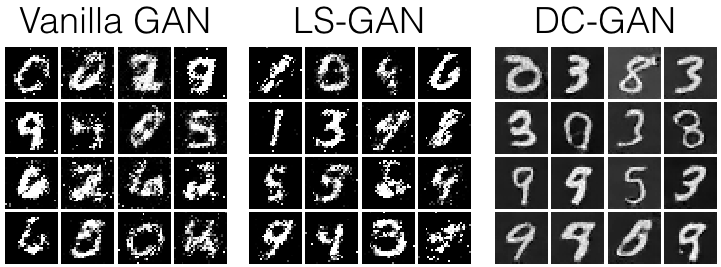

In [40]:
# Run this cell to see sample outputs.
from IPython.display import Image
Image('images/gan_outputs_pytorch.png')

In [41]:
# Setup cell.
import numpy as np
import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from cs231n.gan_pytorch import preprocess_img, deprocess_img, rel_error, count_params, ChunkSampler

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # Set default size of plots.
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1]) # Images reshape to (batch_size, D).
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

answers = dict(np.load('gan-checks.npz'))
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset
 GANs are notoriously finicky with hyperparameters, and also require many training epochs. In order to make this assignment approachable, we will be working on the MNIST dataset, which is 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9). This was one of the first datasets used to train convolutional neural networks and it is fairly easy -- a standard CNN model can easily exceed 99% accuracy. 

To simplify our code here, we will use the PyTorch MNIST wrapper, which downloads and loads the MNIST dataset. See the [documentation](https://github.com/pytorch/vision/blob/master/torchvision/datasets/mnist.py) for more information about the interface. The default parameters will take 5,000 of the training examples and place them into a validation dataset. The data will be saved into a folder called `MNIST_data`. 

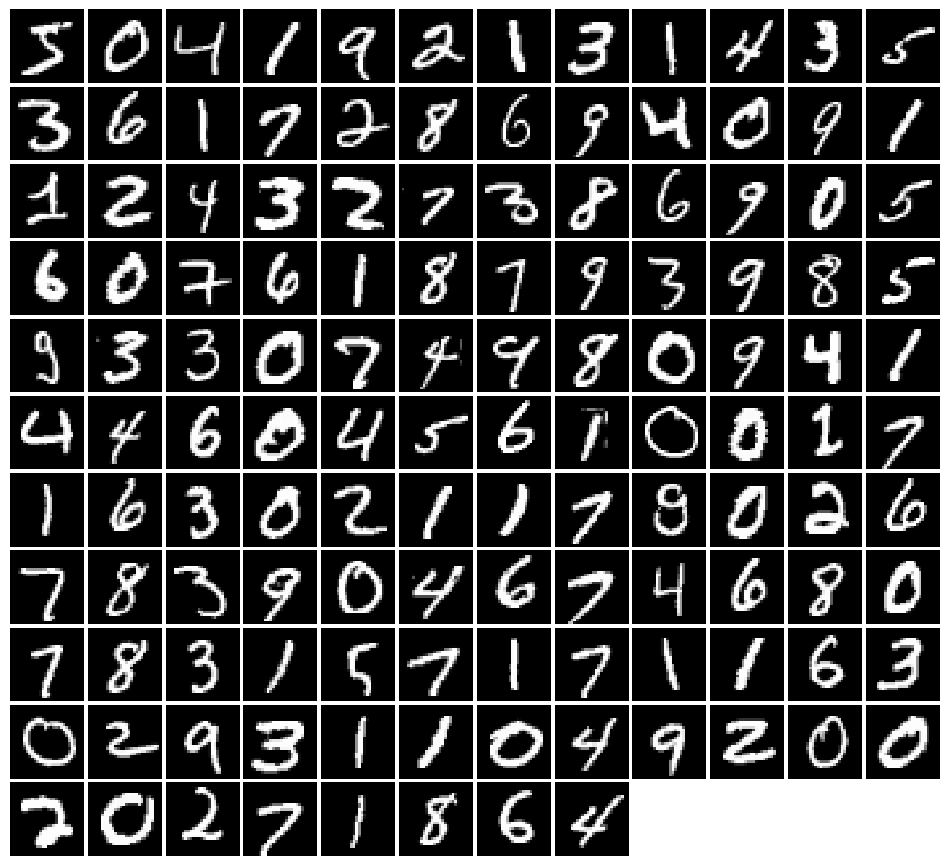

In [42]:
NUM_TRAIN = 50000
NUM_VAL = 5000

NOISE_DIM = 96
batch_size = 128

mnist_train = dset.MNIST(
    './cs231n/datasets/MNIST_data',
    train=True,
    download=True,
    transform=T.ToTensor()
)
loader_train = DataLoader(
    mnist_train,
    batch_size=batch_size,
    sampler=ChunkSampler(NUM_TRAIN, 0)
)

mnist_val = dset.MNIST(
    './cs231n/datasets/MNIST_data',
    train=True,
    download=True,
    transform=T.ToTensor()
)
loader_val = DataLoader(
    mnist_val,
    batch_size=batch_size,
    sampler=ChunkSampler(NUM_VAL, NUM_TRAIN)
)

iterator = iter(loader_train)
imgs, labels = next(iterator)
imgs = imgs.view(batch_size, 784).numpy().squeeze()
show_images(imgs)

## Random Noise
Generate uniform noise from -1 to 1 with shape `[batch_size, dim]`.

Implement `sample_noise` in `cs231n/gan_pytorch.py`.

Hint: use `torch.rand`.

Make sure noise is the correct shape and type:

In [43]:
from cs231n.gan_pytorch import sample_noise

def test_sample_noise(): 
    batch_size = 3
    dim = 4
    torch.manual_seed(231)
    z = sample_noise(batch_size, dim)
    np_z = z.cpu().numpy()
    assert np_z.shape == (batch_size, dim)
    assert torch.is_tensor(z)
    assert np.all(np_z >= -1.0) and np.all(np_z <= 1.0)
    assert np.any(np_z < 0.0) and np.any(np_z > 0.0)
    print('All tests passed!')
    
test_sample_noise()

All tests passed!


## Flatten

Recall our Flatten operation from previous notebooks... this time we also provide an Unflatten, which you might want to use when implementing the convolutional generator. We also provide a weight initializer (and call it for you) that uses Xavier initialization instead of PyTorch's uniform default.

In [44]:
from cs231n.gan_pytorch import Flatten, Unflatten, initialize_weights

# 分类器
我们的第一步是构建一个分类器。在下方函数中，将架构作为 `nn.Sequential` 构造函数的一部分填入。所有全连接层均应包含偏置项。架构如下：
* 输入尺寸为 784、输出尺寸为 256 的全连接层
* LeakyReLU 激活函数，alpha 值为 0.01
 * 输入大小为 256、输出大小为 256 的全连接层
 * LeakyReLU 激活函数，alpha 值为 0.01
 * 输入大小为 256、输出大小为 1 的全连接层
 
需注意，Leaky ReLU 非线性函数计算 $f(x) = \max(\alpha x, x)$，其中 $\alpha$ 为固定常数；在上述架构中，我们设置 $\alpha=0.01$。
 
判别器的输出应具有形状 `[batch_size, 1]`，并包含实数，对应于每个 `batch_size` 输入是否为真实图像的评分。

在 `cs231n/gan_pytorch.py` 中实现 `discriminator`。

Test to make sure the number of parameters in the discriminator is correct:

In [45]:
from cs231n.gan_pytorch import discriminator

def test_discriminator(true_count=267009):
    model = discriminator()
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in discriminator. Check your achitecture.')
    else:
        print('Correct number of parameters in discriminator.')     

test_discriminator()

Correct number of parameters in discriminator.


# Generator
Now to build the generator network:
 * Fully connected layer from noise_dim to 1024
 * `ReLU`
 * Fully connected layer with size 1024 
 * `ReLU`
 * Fully connected layer with size 784
 * `TanH` (to clip the image to be in the range of [-1,1])
 
 Implement `generator` in `cs231n/gan_pytorch.py`

Test to make sure the number of parameters in the generator is correct:

In [46]:
from cs231n.gan_pytorch import generator

def test_generator(true_count=1858320):
    model = generator(4)
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in generator. Check your achitecture.')
    else:
        print('Correct number of parameters in generator.')

test_generator()

Correct number of parameters in generator.


# GAN 损失

计算生成器和判别器的损失。生成器损失为：
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
判别器损失为：
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
注意，这些方程与之前给出的方程相反，因为我们将要*最小化*这些损失。

**提示**：你应该使用下面定义的`bce_loss`函数来计算二元交叉熵损失，该损失用于计算鉴别器输出的logits对应的真实标签的对数概率。给定一个分数$s\in\mathbb{R}$和一个标签$y\in\{0, 1\}$，二元交叉熵损失为

$$ bce(s, y) = -y * \log(s) - (1 - y) * \log(1 - s) $$

该公式的简单实现可能存在数值不稳定性，因此我们提供了基于 PyTorch 的 `nn.BCEWithLogitsLoss` 的数值稳定实现。

你还需要计算对应于真实或伪造的标签，并使用 logit 参数来确定其大小。确保你使用全局 `dtype` 变量将这些标签转换为正确的数据类型，例如：


`true_labels = torch.ones(size).type(dtype)`

我们不再计算 $\log D(G(z))$、$\log D(x)$ 和 $\log \left(1-D(G(z))\right)$ 的期望值，而是对小批量中的元素进行求平均。这一操作在 `bce_loss` 中通过求平均来实现损失的合并。

在 `cs231n/gan_pytorch.py` 中实现 `discriminator_loss` 和 `generator_loss`。

通过DeepL.com（免费版）翻译

Test your generator and discriminator loss. You should see errors < 1e-7.

In [47]:
from cs231n.gan_pytorch import bce_loss, discriminator_loss, generator_loss

def test_discriminator_loss(logits_real, logits_fake, d_loss_true):
    d_loss = discriminator_loss(torch.Tensor(logits_real).type(dtype),
                                torch.Tensor(logits_fake).type(dtype)).cpu().numpy()
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))

test_discriminator_loss(
    answers['logits_real'],
    answers['logits_fake'],
    answers['d_loss_true']
)

Maximum error in d_loss: 3.97058e-09


In [48]:
def test_generator_loss(logits_fake, g_loss_true):
    g_loss = generator_loss(torch.Tensor(logits_fake).type(dtype)).cpu().numpy()
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_generator_loss(
    answers['logits_fake'],
    answers['g_loss_true']
)

Maximum error in g_loss: 4.4518e-09


# Optimizing our Loss
Make a function that returns an `optim.Adam` optimizer for the given model with a 1e-3 learning rate, beta1=0.5, beta2=0.999. You'll use this to construct optimizers for the generators and discriminators for the rest of the notebook.

Implement `get_optimizer` in `cs231n/gan_pytorch.py`

# Training a GAN!

We provide you the main training loop. You won't need to change `run_a_gan` in `cs231n/gan_pytorch.py`, but we encourage you to read through it for your own understanding.

In [49]:
from cs231n.gan_pytorch import get_optimizer, run_a_gan

# Make the discriminator
D = discriminator().type(dtype)

# Make the generator
G = generator().type(dtype)

# Use the function you wrote earlier to get optimizers for the Discriminator and the Generator
D_solver = get_optimizer(D)
G_solver = get_optimizer(G)

# Run it!
images = run_a_gan(
    D,
    G,
    D_solver,
    G_solver,
    discriminator_loss,
    generator_loss,
    loader_train
)

Iter: 0, D: 1.328, G:0.7202
Iter: 250, D: 1.636, G:0.6495
Iter: 500, D: 1.368, G:0.9284
Iter: 750, D: 1.314, G:0.906
Iter: 1000, D: 1.111, G:1.08
Iter: 1250, D: 1.177, G:1.086
Iter: 1500, D: 1.288, G:0.7703
Iter: 1750, D: 1.281, G:0.9545
Iter: 2000, D: 1.248, G:0.9224
Iter: 2250, D: 1.314, G:0.8411
Iter: 2500, D: 1.306, G:0.7864
Iter: 2750, D: 1.296, G:0.7834
Iter: 3000, D: 1.303, G:0.7951
Iter: 3250, D: 1.264, G:0.792
Iter: 3500, D: 1.315, G:0.8298
Iter: 3750, D: 1.382, G:0.8725


Run the cell below to show the generated images.

Iter: 0


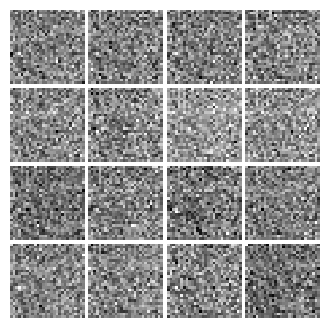


Iter: 250


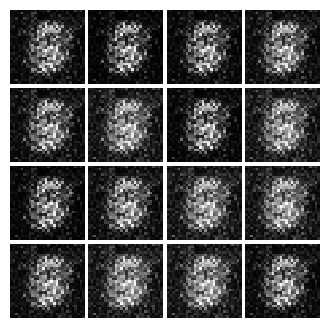


Iter: 500


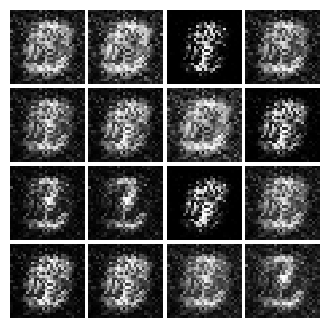


Iter: 750


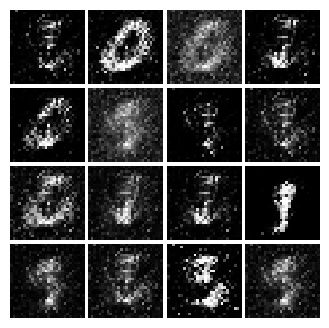


Iter: 1000


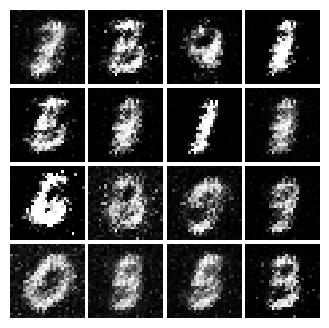


Iter: 1250


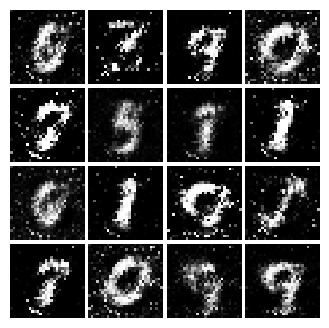


Iter: 1500


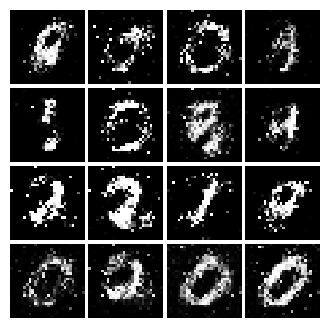


Iter: 1750


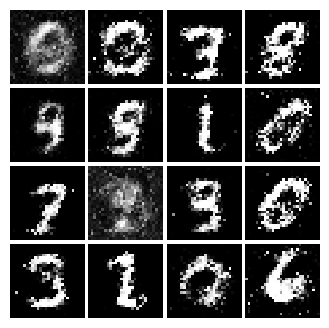


Iter: 2000


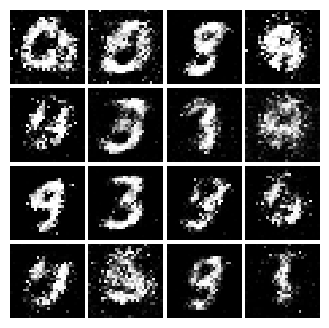


Iter: 2250


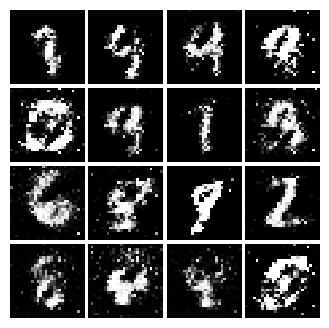


Iter: 2500


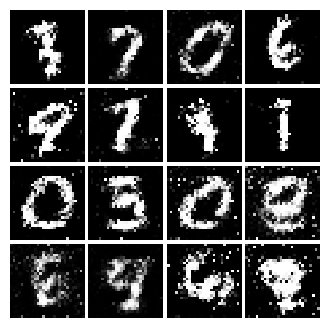


Iter: 2750


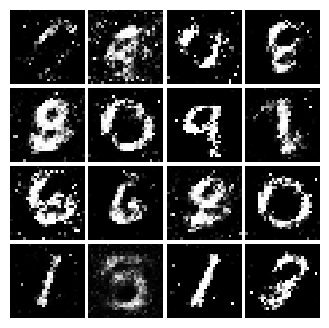


Iter: 3000


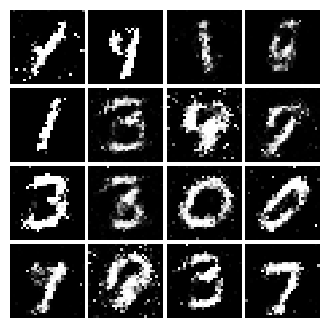


Iter: 3250


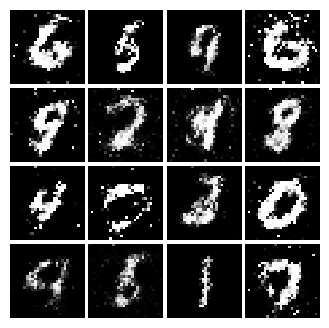


Iter: 3500


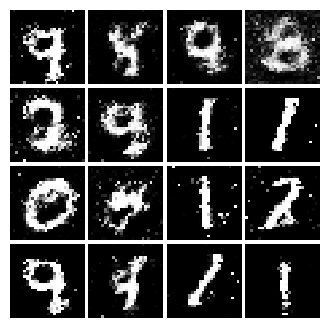


Iter: 3750


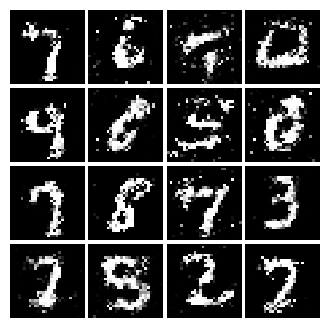

In [50]:
numIter = 0
for img in images:
    print("Iter: {}".format(numIter))
    show_images(img)
    plt.show()
    numIter += 250
    print()

## Inline Question 1

What does your final vanilla GAN image look like?

Vanilla GAN final image:


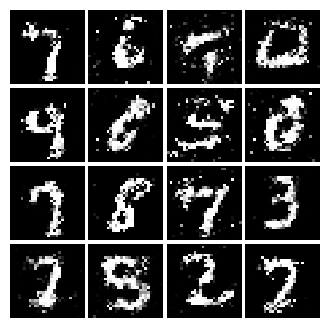

In [51]:
# This output is your answer.
print("Vanilla GAN final image:")
show_images(images[-1])
plt.show()

Well that wasn't so hard, was it? In the iterations in the low 100s you should see black backgrounds, fuzzy shapes as you approach iteration 1000, and decent shapes, about half of which will be sharp and clearly recognizable as we pass 3000.

# 最小二乘生成对抗网络（Least Squares GAN）
我们将探讨[最小二乘生成对抗网络](https://arxiv.org/abs/1611.04076)，这是对原始生成对抗网络（GAN）损失函数的一种更新、更稳定的替代方案。对于这一部分，我们只需修改损失函数并重新训练模型即可。我们将实现论文中的方程 (9)，其中生成器损失为：
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
鉴别器损失为：
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$


**提示**：我们不需要计算期望值，而是对小批量中的元素进行求平均，因此请确保通过求平均而非求和来合并损失。在代入 $D(x)$ 和 $D(G(z))$ 时，请使用鉴别器的直接输出（`scores_real` 和 `scores_fake`）。

在 `cs231n/gan_pytorch.py` 中实现 `ls_discriminator_loss` 和 `ls_generator_loss`。

Before running a GAN with our new loss function, let's check it:

In [52]:
from cs231n.gan_pytorch import ls_discriminator_loss, ls_generator_loss

def test_lsgan_loss(score_real, score_fake, d_loss_true, g_loss_true):
    score_real = torch.Tensor(score_real).type(dtype)
    score_fake = torch.Tensor(score_fake).type(dtype)
    d_loss = ls_discriminator_loss(score_real, score_fake).cpu().numpy()
    g_loss = ls_generator_loss(score_fake).cpu().numpy()
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_lsgan_loss(
    answers['logits_real'],
    answers['logits_fake'],
    answers['d_loss_lsgan_true'],
    answers['g_loss_lsgan_true']
)

Maximum error in d_loss: 1.53171e-08
Maximum error in g_loss: 2.7837e-09


Run the following cell to train your model!

In [53]:
D_LS = discriminator().type(dtype)
G_LS = generator().type(dtype)

D_LS_solver = get_optimizer(D_LS)
G_LS_solver = get_optimizer(G_LS)

images = run_a_gan(
    D_LS,
    G_LS,
    D_LS_solver,
    G_LS_solver,
    ls_discriminator_loss,
    ls_generator_loss,
    loader_train
)

Iter: 0, D: 0.5689, G:0.51
Iter: 250, D: 0.2408, G:0.2108
Iter: 500, D: 0.1224, G:0.3983
Iter: 750, D: 0.1276, G:0.3081
Iter: 1000, D: 0.1538, G:0.2802
Iter: 1250, D: 0.1333, G:0.2072
Iter: 1500, D: 0.1498, G:0.2451
Iter: 1750, D: 0.1946, G:0.237
Iter: 2000, D: 0.2279, G:0.12
Iter: 2250, D: 0.2063, G:0.1802
Iter: 2500, D: 0.233, G:0.1768
Iter: 2750, D: 0.2118, G:0.1868
Iter: 3000, D: 0.2386, G:0.1583
Iter: 3250, D: 0.2171, G:0.1695
Iter: 3500, D: 0.2425, G:0.157
Iter: 3750, D: 0.2362, G:0.156


Run the cell below to show generated images.

Iter: 0


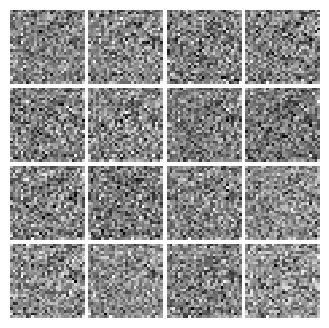


Iter: 250


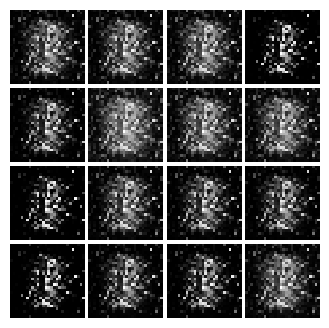


Iter: 500


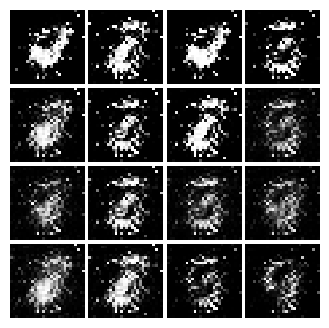


Iter: 750


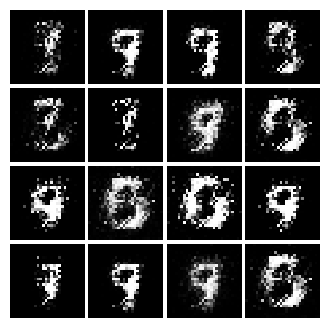


Iter: 1000


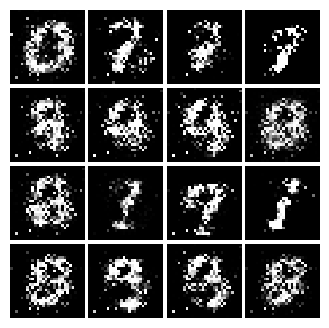


Iter: 1250


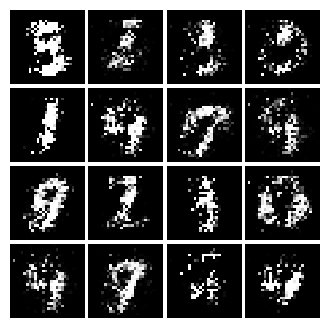


Iter: 1500


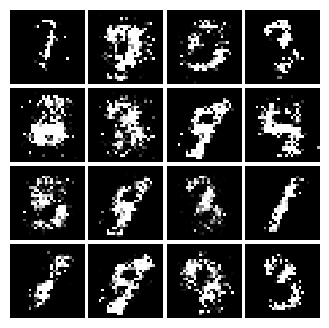


Iter: 1750


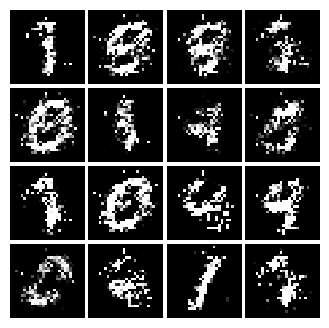


Iter: 2000


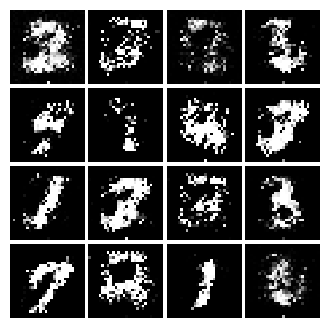


Iter: 2250


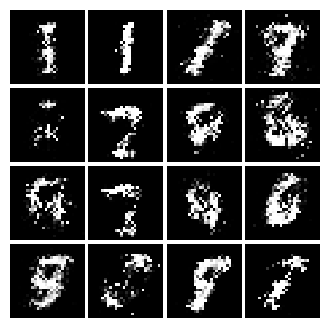


Iter: 2500


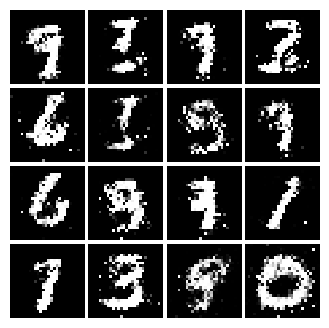


Iter: 2750


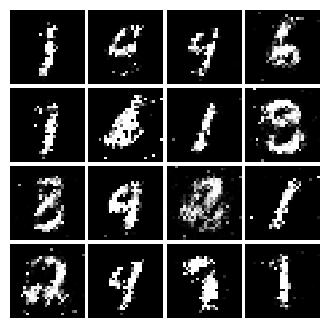


Iter: 3000


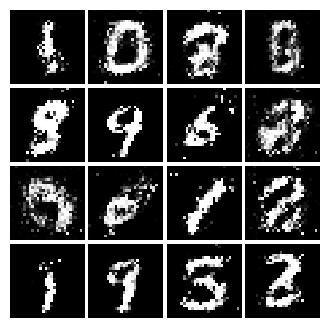


Iter: 3250


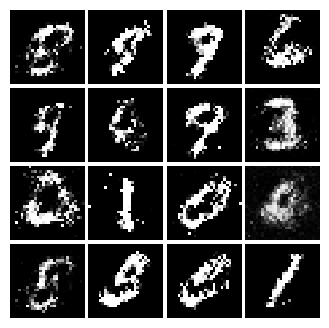


Iter: 3500


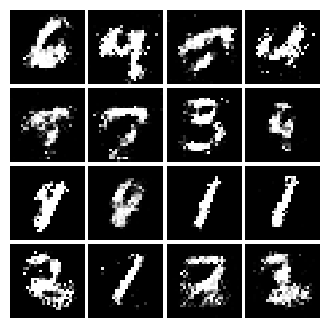


Iter: 3750


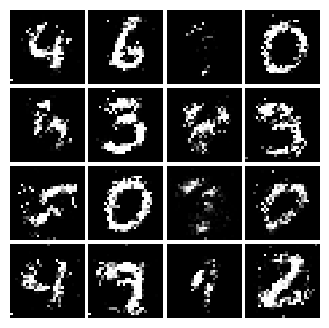

In [54]:
numIter = 0
for img in images:
    print("Iter: {}".format(numIter))
    show_images(img)
    plt.show()
    numIter += 250
    print()

## Inline Question 2

What does your final LSGAN image look like?

LSGAN final image:


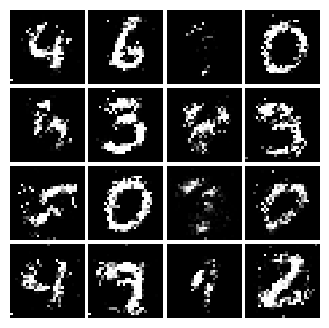

In [55]:
# This output is your answer.
print("LSGAN final image:")
show_images(images[-1])
plt.show()

# 深度卷积生成对抗网络（DCGAN）
在笔记本的第一部分，我们几乎直接复制了Ian Goodfellow提出的原始生成对抗网络（GAN）架构。然而，该网络架构无法进行真正的空间推理。由于缺乏卷积层，它无法对“锐利边缘”等特征进行推理。因此，在本节中，我们将实现[DCGAN](https://arxiv.org/abs/1511.06434)中的一些想法，其中我们使用卷积网络 

#### 分辨器
我们将使用一个受TensorFlow MNIST分类教程启发的分辨器，该分辨器能够在MNIST数据集上快速实现超过99%的准确率。
* Conv2D：32个滤波器，5x5，步长1
* Leaky ReLU（alpha=0.01）
* 最大池化2x2，步长2
* Conv2D：64个滤波器，5x5，步长1
* Leaky ReLU（alpha=0.01）
* 最大池化 2x2，步长 2
* 展平
* 全连接层，输出尺寸 4x4x64
* 泄漏 ReLU（alpha=0.01）
* 全连接层，输出尺寸 1

在 `cs231n/gan_pytorch.py` 中实现 `build_dc_classifier` 函数。

In [63]:
from cs231n.gan_pytorch import build_dc_classifier

data = next(enumerate(loader_train))[-1][0].type(dtype)
b = build_dc_classifier(batch_size).type(dtype)
out = b(data)
print(out.size())

torch.Size([128, 1])


Check the number of parameters in your classifier as a sanity check:

In [64]:
def test_dc_classifer(true_count=1102721):
    model = build_dc_classifier(batch_size)
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in classifier. Check your achitecture.')
    else:
        print('Correct number of parameters in classifier.')

test_dc_classifer()

Correct number of parameters in classifier.


#### Generator
For the generator, we will copy the architecture exactly from the [InfoGAN paper](https://arxiv.org/pdf/1606.03657.pdf). See Appendix C.1 MNIST. See the documentation for [nn.ConvTranspose2d](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html). We are always "training" in GAN mode. 
* Fully connected with output size 1024
* `ReLU`
* BatchNorm
* Fully connected with output size 7 x 7 x 128 
* ReLU
* BatchNorm
* Use `Unflatten()` to reshape into Image Tensor of shape 7, 7, 128
* ConvTranspose2d: 64 filters of 4x4, stride 2, 'same' padding (use `padding=1`)
* `ReLU`
* BatchNorm
* ConvTranspose2d: 1 filter of 4x4, stride 2, 'same' padding (use `padding=1`)
* `TanH`
* Should have a 28x28x1 image, reshape back into 784 vector (using `Flatten()`)

Implement `build_dc_generator` in `cs231n/gan_pytorch.py`

In [65]:
from cs231n.gan_pytorch import build_dc_generator

test_g_gan = build_dc_generator().type(dtype)
test_g_gan.apply(initialize_weights)

fake_seed = torch.randn(batch_size, NOISE_DIM).type(dtype)
fake_images = test_g_gan.forward(fake_seed)
fake_images.size()

torch.Size([128, 784])

Check the number of parameters in your generator as a sanity check:

In [66]:
def test_dc_generator(true_count=6580801):
    model = build_dc_generator(4)
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in generator. Check your achitecture.')
    else:
        print('Correct number of parameters in generator.')

test_dc_generator()

Correct number of parameters in generator.


In [67]:
D_DC = build_dc_classifier(batch_size).type(dtype) 
D_DC.apply(initialize_weights)
G_DC = build_dc_generator().type(dtype)
G_DC.apply(initialize_weights)

D_DC_solver = get_optimizer(D_DC)
G_DC_solver = get_optimizer(G_DC)

images = run_a_gan(
    D_DC,
    G_DC,
    D_DC_solver,
    G_DC_solver,
    discriminator_loss,
    generator_loss,
    loader_train,
    num_epochs=5
)

Iter: 0, D: 1.408, G:0.3742
Iter: 250, D: 1.305, G:0.4057
Iter: 500, D: 1.235, G:0.9441
Iter: 750, D: 1.149, G:0.8744
Iter: 1000, D: 1.199, G:0.9851
Iter: 1250, D: 1.347, G:1.074
Iter: 1500, D: 1.226, G:0.8762


KeyboardInterrupt: 

Run the cell below to show generated images.

Iter: 0


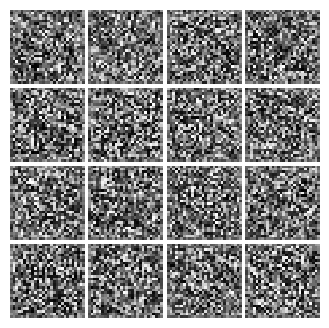


Iter: 250


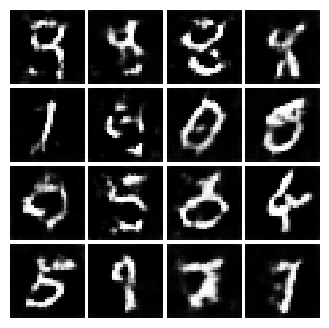


Iter: 500


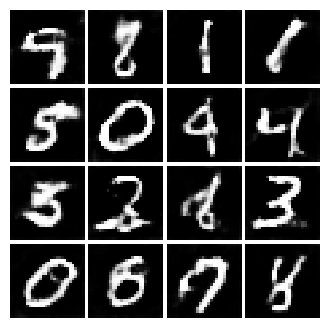


Iter: 750


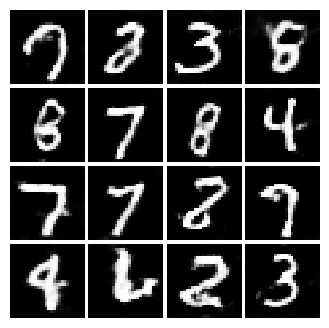


Iter: 1000


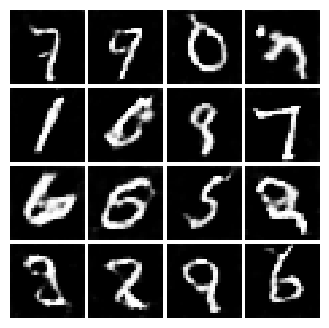


Iter: 1250


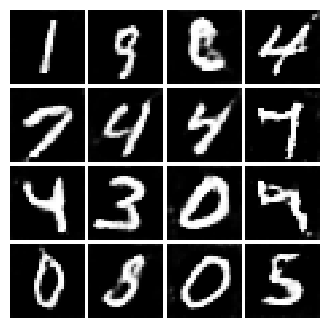


Iter: 1500


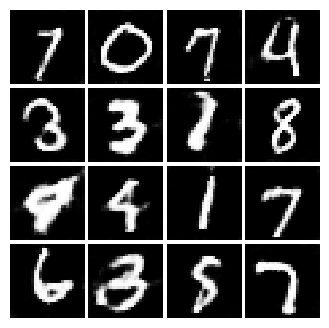


Iter: 1750


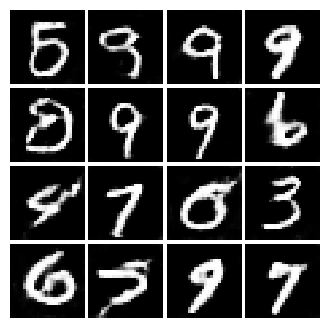

In [ ]:
numIter = 0
for img in images:
    print("Iter: {}".format(numIter))
    show_images(img)
    plt.show()
    numIter += 250
    print()

## Inline Question 3

What does your final DCGAN image look like?

DCGAN final image:


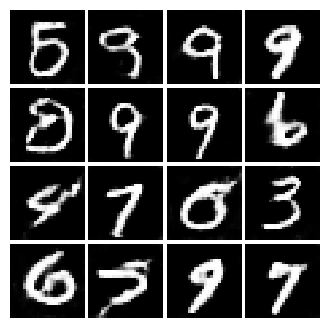

In [ ]:
# This output is your answer.
print("DCGAN final image:")
show_images(images[-1])
plt.show()

## 嵌入式问题 4

我们将通过一个例子来探讨为什么对同一目标函数进行交替最小化（如在生成对抗网络（GAN）中）可能会变得复杂。

考虑函数 $f(x,y)=xy$。$\min_x\max_y f(x,y)$ 的值是多少？（提示：minmax 试图最小化可达的最大值。）

现在尝试对该函数进行6次数值计算，初始点为$(1,1)$，
使用交替梯度法（先更新$y$，再用更新后的$y$更新$x$），步长为$1$。**此处步长即学习率，而步数为学习率乘以梯度。**
你会发现，用 $x_t,y_t,x_{t+1},y_{t+1}$ 表示更新步骤会很有用。

简要解释 $\min_x\max_y f(x,y)$ 的计算结果，并在下表中记录六对明确的 $(x_t,y_t)$ 值。

### 你的答案：

 
 $y_0$ | $y_1$ | $y_2$ | $y_3$ | $y_4$ | $y_5$ | $y_6$ 
 ----- | ----- | ----- | ----- | ----- | ----- | ---- - 
   1   |       |       |       |       |       |       
 $x_0$ | $x_1$ | $x_2$ | $x_3$ | $x_4$ | $x_5$ | $x_6$ 
   1   |       |       |       |       |       |       
   

## Inline Question 5
Using this method, will we ever reach the optimal value? Why or why not?

### Your answer: 


## Inline Question 6
If the generator loss decreases during training while the discriminator loss stays at a constant high value from the start, is this a good sign? Why or why not? A qualitative answer is sufficient.

### Your answer: 
